# BOMR 2021

Ludovic Dauvin, 288 407 <br>
Théo Stanislaw Gieruc, 282 360 <br>
Jonathan Henry, 287 725 <br>
Guillaume Eliot Krafft, 289 256 <br>




## Introduction

Starting the project we first decided which algorithms we wanted to use. 
Concerning the global navigation, we chose to use a visibility graph combined with the Dijkstra algorithm to find the shortest path. 
For the filtering part, we used a Kalman filter and for the local avoidance we used a Braintenberg approach.
We then designed the setup in which the robot would move. 
The floor is white in order to have a good contrast with the other elements. We chose red, green and blue to easily detect the elements with rgb values :
<ul>
<li> Red represents the robot, therefore we sticked a red triangle on top of the thymio.
<li> Green was chosen to represent the goal.
<li> Blue is used to represent the different shaped fixed obstacles.
</ul>
We use a white cylinder as a mobile obstacle for local avoidance.<br>
A lectern and a handcrafted cardboard arm were used in order to place the camera on top of the playing field with a centered view. 


## Module description 

### Vision
The vision module handles everything related to the camera. There are four classes : *vision, robot, obstacle* and *target*.
The class Vision is the main class and contains a robot, obstacle and target element.

The vision is mainly based on color differentiation. The following part will demonstrate the whole process


We will use a picture as an example of what the camera could see.

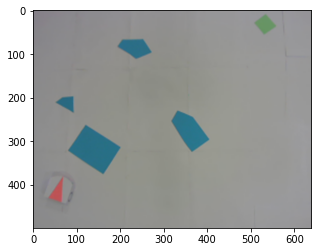

In [1]:
import sys as _sys
import matplotlib.pyplot as plt
import numpy as np
import cv2
from copy import deepcopy

actual_frame = cv2.imread("demo_img/vision_demo.png", cv2.IMREAD_COLOR)
actual_frame = cv2.cvtColor(actual_frame, cv2.COLOR_BGR2RGB)
plt.imshow(actual_frame)

Each color has to be set individually. To do this, we decided to use the Color Picker from ipywidget. As this is a demo, the colors has already been picked

In [2]:
robot_color = np.array([189, 84, 83])
target_color = np.array([103, 148, 100])
obstacles_color = np.array([ 42, 115, 139])

We also have to choose the threshold for each color. The better the uniformity of the color, the lower the thresholds needs to be. As the colors are very uniform, we can use low thresholds.

In [3]:
targetthresh = 20
robotthresh = 20
obstaclesthresh = 20

#### Robot detection
In order to detect the red triangle on top the robot, we first compare the actual frame with the supposed color of the robot

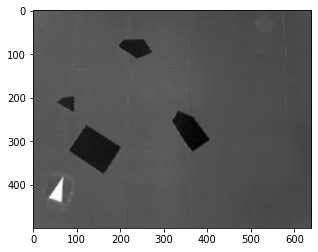

In [4]:
compare_color = abs(actual_frame - robot_color)
compare_gray = np.mean(compare_color, axis=2)
plt.imshow(compare_gray, 'binary')

From this, we get a binary image, using the threshold set before

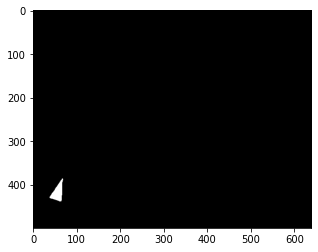

In [5]:
_, binary_img = cv2.threshold(compare_gray, robotthresh, 10, cv2.THRESH_BINARY)
plt.imshow(binary_img,'binary')

Now, we can use cv2.findContours and cv2.approxPolyDP in order to get the triangular shape. We check that the area is big enough and that the shape is actually a triangle.

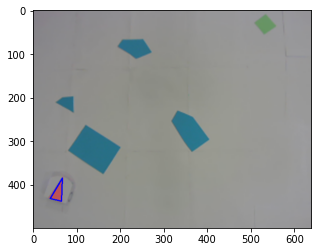

In [6]:
robot_contour, _ = cv2.findContours(binary_img.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
robot_contour = cv2.approxPolyDP(robot_contour[1], 0.03 * cv2.arcLength(robot_contour[1], True), True).reshape(-1,2)
area = cv2.contourArea(robot_contour)
assert(40 < area <  actual_frame.shape[0] * actual_frame.shape[1])
assert(robot_contour.shape[0] == 3)

# Show the results
plt.imshow(cv2.drawContours(actual_frame.copy(), [robot_contour], 0, (0,0,255), 2))

From there, we can find the center of the robot, its orientation using the bisector, and the coefficient pixel / cm, knowing the real length of an edge of the triangle.

the coef mm to px is :  0.4757244997074759


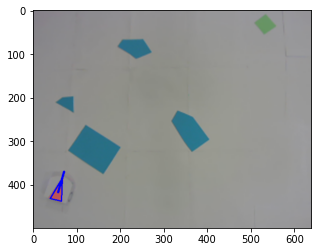

In [7]:
center = np.zeros(2)
M = cv2.moments(robot_contour)
center[0] = int(M['m10'] / M['m00'])
center[1] = int(M['m01'] / M['m00'])

LENGTH_EDGE = 115

dist = np.zeros(3)
dist[0] = np.linalg.norm(robot_contour[2] - robot_contour[1])
dist[1] = np.linalg.norm(robot_contour[0] - robot_contour[2])
dist[2] = np.linalg.norm(robot_contour[0] - robot_contour[1])
max_id = np.argmin(dist)
orientation = np.arctan2(robot_contour[max_id, 1] - center[1], robot_contour[max_id, 0] -  center[0])
mm2px = max(dist) / LENGTH_EDGE
_, robot_length = cv2.minEnclosingCircle(robot_contour)
print("the coef mm to px is : ", mm2px)

# Show the results
contour_img = cv2.drawContours(actual_frame.copy(), [robot_contour], 0, (0,0,255), 2)
point = (center + np.array([np.cos(orientation) * 50, np.sin(orientation) * 50])).astype(int)
contour_orientation_img = cv2.line(contour_img, center.astype(int), point, (0, 0, 255), thickness=3, lineType=8)
plt.imshow(contour_orientation_img)

#### Obstacles
The same can be done to find the contours of the obstacles.

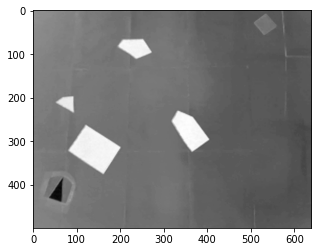

In [8]:
compare_color = abs(actual_frame - obstacles_color)
compare_gray = np.mean(compare_color, axis=2)
plt.imshow(compare_gray, 'binary')

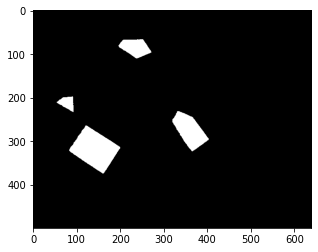

In [9]:
_, binary_img = cv2.threshold(compare_gray, obstaclesthresh, 10, cv2.THRESH_BINARY)
plt.imshow(binary_img, 'binary')

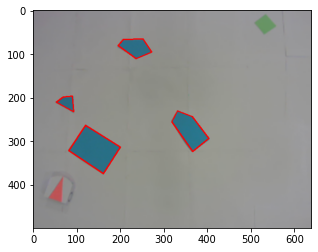

In [10]:
def polygon_detection(binary_img):
    contours, _ = cv2.findContours(binary_img.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    approx_cnt = []

    for cnt in contours:
        approx = cv2.approxPolyDP(cnt, 0.03 * cv2.arcLength(cnt, True), True)
        area = cv2.contourArea(approx)
        if 40 < area < 0.8 * actual_frame.shape[0] * actual_frame.shape[1]:
            approx_cnt.append(approx.reshape(-1, 2))

    return approx_cnt

obstacle_contours = polygon_detection(binary_img)
# Show the results
img_mask = actual_frame.copy()
for cnt in obstacle_contours:
    cv2.drawContours(img_mask, [cnt], 0, (255, 0, 0), 2)

plt.imshow(img_mask)

We need to expand the contours to get the points where the Thymio could fit.

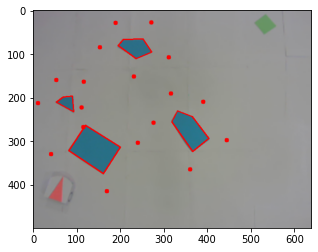

In [11]:
expanded_obstacle_contours = deepcopy(obstacle_contours)
for i, cnt in enumerate(obstacle_contours):
    for j, corner in enumerate(cnt):
        e1 = cnt[(j - 1) % cnt.shape[0]] - corner
        e2 = cnt[(j + 1) % cnt.shape[0]] - corner
        bisector = (e1 / np.linalg.norm(e1) + e2 / np.linalg.norm(e2))
        expanded_obstacle_contours[i][j] = corner - 1.5 * robot_length * bisector / np.linalg.norm(bisector)

# Show the results
extended_obstacles_img = actual_frame.copy()
for cnt in expanded_obstacle_contours:
    cnt = cnt.astype(int)
    for dot in cnt:
        img = cv2.circle(extended_obstacles_img, dot.flatten(), 5, (255, 0, 0), -1)

for cnt in obstacle_contours:
    cv2.drawContours(extended_obstacles_img, [cnt], 0, (255, 0, 0), 2)

plt.imshow(extended_obstacles_img)

Some contours are close enough to prevent the Thymio from going in between. We can merge them together.
To do so, we first draw the expanded obstacles then we detect the contour of the generated image

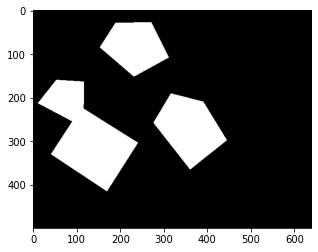

In [12]:
img = 255 * np.ones_like(actual_frame[:, :, 0])
for cnt in expanded_obstacle_contours:
    cv2.drawContours(img, [cnt], 0, 0, thickness=cv2.FILLED)
expanded_obstacle_contours = polygon_detection(img)
plt.imshow(img, 'binary')

Some contours are not convex. We can make them convex using cv2.convexHull()

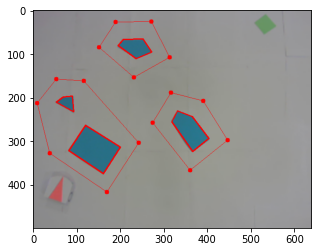

In [13]:
img = 255 * np.ones_like(actual_frame[:, :, 0])
for contour in expanded_obstacle_contours:
    cv2.drawContours(img, [cv2.convexHull(contour)], 0, 0, thickness=cv2.FILLED)
expanded_obstacle_contours_convex = polygon_detection(img)
# Show the results
extended_obstacles_img = actual_frame.copy()
for cnt in expanded_obstacle_contours_convex:
    cnt = cnt.astype(int)
    for dot in cnt:
        cv2.circle(extended_obstacles_img, dot.flatten(), 5, (255, 0, 0), -1)

for cnt in expanded_obstacle_contours_convex:
    cv2.drawContours(extended_obstacles_img, [cnt], 0, (255, 0, 0), 1)

for cnt in obstacle_contours:
    cv2.drawContours(extended_obstacles_img, [cnt], 0, (255, 0, 0), 2)

plt.imshow(extended_obstacles_img)

#### Target
We only need to find the center of the contour, using the same method as before

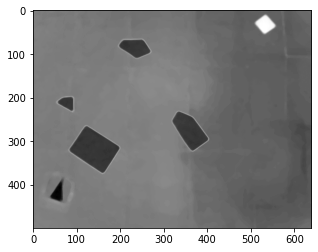

In [14]:
compare_color = abs(cv2.medianBlur(actual_frame, 9)
 - target_color)
compare_gray = np.mean(compare_color, axis=2)
plt.imshow(compare_gray,'binary')

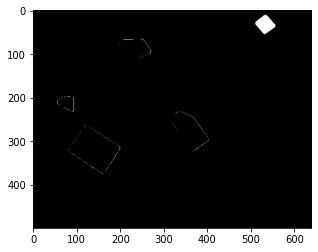

In [15]:
_, binary_img = cv2.threshold(compare_gray, targetthresh, 10, cv2.THRESH_BINARY)
plt.imshow(binary_img,'binary')

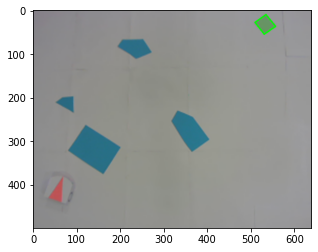

In [16]:
target_contour = polygon_detection(binary_img)[0]

# Show the results
plt.imshow(cv2.drawContours(actual_frame.copy(), [target_contour], 0, (0,255,0), 2))


### Global Navigation 

### Filtering
The filtering was done using a Kalman Filter. We designed it to use the position and the angle given by the camera as measurement and the speed of the robot, given by the sensors of the wheels, as prediction. For simplicity of use, we decided to create a Kalman_Filter class, so we would have less arguments to give to each functions. However, this class needs to have access to the class Vision and to be given the speed of the robot to work properly.


#### Equations
The Kalman filter merge together a prediction of the future state of the system with a measure of these states to be more precise. The prediction is govern by the system equations. In this section, we are going to describe the equations used in the model and the ones used to implement the merging part of the filter.
First, we need to convert the informations we get from the sensors to something we can use:
$v = (v_r + v_l)/2$. This is the translational speed and $w = (v_r - v_l)/b$, which is the rotationnal speed. $v_r$ is the speed of the right wheel, $v_l$ the left one and $b$ is the width of the robot, wheel to wheel. These speed are given in thymio units, so we need to convert them in mm or in pixels to use them with the other values. For w, we just want to change it to mm because b is given in mm and for v, the position are given in pixels unit so we have to convert it first to mm and then to pixels.
From $w$, we can compute the variation of angle that the robot does when it moves: $\alpha = w \cdot \delta t$.
We have three states for our filter, which are $x$, $y$, and $\theta$, respectively the position on the x and y axis and the orientation from the x axis. The state vector is called $\rho$ and the vector of input ($[v ; w]$) is called u for simplication of writing. Therefore, the model equation is the following: $\rho_{k+1} = A \cdot \rho_k + B \cdot u_k$. We now need to determine the matrixes A and B. For this, we have to know how the system evolve with each steps. For x, we can find that $x_{k+1} = x_k + v \cdot \cos(\alpha + \theta) \cdot \delta t$ and for y: $y_{k+1} = y_k + v \cdot\sin(\alpha + \theta)\cdot \delta t$. Finally, for $\theta$, we have $\theta_{k+1} = \theta_k + w \cdot\delta t$. From this we can find that the matrix A is  \begin{bmatrix} 1 & 0 & 0\\ 0 & 1 & 0 \\ 0 & 0 & 1\end{bmatrix} and the B matrix  \begin{bmatrix} \cos(\alpha + \theta) \cdot \delta t & 0\\ \sin(\alpha + \theta) \cdot \delta t & 0 \\ 0 & \delta t \end{bmatrix}
We now have a model for the predictive part of our algorithm.

In [17]:
import numpy as np
pos = [50, 60, np.pi/4]
speed = [200, 200]
b = 100
THYMIO_SPEED_2_MM = 0.435
mm2px = 0.5
time = 0.1
P_est = 1000 * np.ones(3)
Q = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0.1]])

v = mm2px * THYMIO_SPEED_2_MM *(speed[0] + speed[1])/2
w = THYMIO_SPEED_2_MM *(speed[0] - speed[1])/b
alpha = w * time
rho_est = pos
u = np.array([v, w])

A = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
B = np.array([[time * np.cos(alpha + rho_est[2]), 0], [time * np.sin(alpha + rho_est[2]), 0], [0, time]])

We can now start the real algorithm of our filter: we start by computing the estimation of our states $\rho_{est\text{ }a\text{ }priori}$ with our model equation. We can then compute the Covariance matrix P: $P_{est \text{ }a\text{ }priori} = A \cdot P_{est} \cdot A^T + Q$ where Q is the error covariance matrix for the estimation and $Q =\begin{bmatrix} 1 & 0 & 0\\ 0 & 1 & 0 \\ 0 & 0 & 0.1\end{bmatrix}$

In [19]:
rho_est_a_priori = np.dot(A, rho_est) + np.dot(B, u)
P_est_a_priori = np.dot(A, np.dot(P_est, A.T)) + Q
print("The estimated position, using only odometry : ", rho_est_a_priori)

The estimated position, using only odometry :  [53.0759145  63.0759145   0.78539816]


now we need to see if the camera gives us measurement or not. This sadly is only possible with the camera connected so for this demo we are setting a variable acting like the function robot_detected() from our vision module.

##### Camera not connected
If the camera is not connected we set the kalman gain to 0 and therefore we do not compute $S$. For $y$, we simply set it to the last known position.

##### Camera connected
If the camera is detected, we set the measurement as the values retourned by the camera, $pos_x$, $pos_y$ and $\theta$. This will be our measurement vector $y$. We also compute the covariance matrix for measurement, $S = C \cdot P_{est \text{ }a\text{ }priori} \cdot C^T + R$, where $C$ is the matrix linking measurements and states and $R$ is the error covariance matrix for the measurement. Finally, we compute the Kalman gain, which is the gain for the measurements $K = P_{est \text{ }a\text{ }priori} \cdot C^T \cdot S^{-1}$.
We chose to have a small R compared to Q because we want to put much more weight on the camera measurements, the speed sensors being less precise. That way, when our camera is active the kalman filter will output almost the same position as the position given by the camera.

In [21]:
C = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
R = np.array([[0.1, 0, 0], [0, 0.1, 0], [0, 0, 0.01]])
robot_detected = 1

In [22]:
if robot_detected:
    y = [50.5, 60.8, 0.77]#the robot went relatively straight. Those are arbitrary values for the demo. These can be changed
    S = np.dot(C, np.dot(P_est_a_priori, C.T)) + R
    K = np.dot(P_est_a_priori, np.dot(C.T, np.linalg.inv(S)))
else:
    K = 0
    y = rho_est

Finally, we compute the innovation (the difference between the measured positions and the estimated positions) $i = y - C \cdot \rho_{est\text{ }a\text{ }priori}$. We can now compute the new estimation of the position $\rho_{est} = \rho_{est\text{ }a\text{ }priori} + K \cdot i$ and the new covariance matrix $P_{est} = (I - K \cdot C) \cdot P_{est\text{ }a\text{ }priori}$


In [23]:
i = y - np.dot(C, rho_est_a_priori)
rho_est = rho_est_a_priori + np.dot(K, i)
P_est = np.dot((np.identity(3) - np.dot(K, C)), P_est_a_priori)

To see the effect of the filter, we can print the value of $\rho_{est}$ and the position given by the camera. Of course, with this example being a static one, the position given by the estimate won't be the same as the one seen by the camera, because the camera gives us the last position and the estimate the next position, but it allows us to see the effect of the filter, for example by changing the speed.

In [25]:
print("The position given by the camera : ", y)
print("The final estimated position : ", rho_est)

The position given by the camera :  [50.5, 60.8, 0.77]
The final estimated position :  [50.69625471 60.96898199  0.7334805 ]


### Local Navigation

The local avoidance of obstacles is done through the use of an ANN (Artificial Neural Network).<br>
In our case we have a single layer neural network composed of two neurons. We feed them the values of the 5 front sensors and they output a speed for each motor in order to avoid the obstacle. We also added a memory which helps the thymio continue moving despite the lack of input from the sensors once the obstacle is partially avoided.

The function is located in 'src/movement' 

In [ ]:
prox_and_memory = np.zeros(7)
k_ann = 1500
offset_ann = 150

def local_avoid(speed_robot, node):
    # global prox_and_memory
    prox_and_memory[0:5] = np.array([x for x in node['prox.horizontal'][0:5]])
    w= np.array([[80, 20, -25, -20, -80, 12, 0],[-80, -20, -20, 20, 80, 0, 12]])
    v= w.dot(prox_and_memory)
    if (abs(v) > 2200).any():
        prox_and_memory[5] = 0
        prox_and_memory[6] = 0
        speed_robot = (v / k_ann).astype(int) + offset_ann
    else:
        speed_robot += (v / 200).astype(int)

    prox_and_memory[5:7] = (speed_robot / 10).astype(int)

    return speed_robot

The function takes as input speed_robot, which is the speed calculated thanks to the other modules (vision and kalman filter)

The weights of the neurons are set in the variable w and were manually tweaked to correctly avoid obstacles. The last two values are used for the memory.

The if statment is there to distinguish two cases : 
<ol>
<li>If the robot is close to the obstacle, it only avoids the object, the speed_robot is completely overwritten by the local avoidance.
<li>If the robot is far enough we add the output of the neurons to robot_speed therfore the robot still wants to go back on its planned trajectory. 

#### runable code (using the thymio) 

The following code is taken from TP3 and can be used to demonstarte the working principle of the ANN. Note that here the code is transpiled in aseba and loaded on the thymio. In the project the sensors values are passed using ClientAsync more on that in the motion control part of this report.

In [ ]:
!pip install --upgrade tdmclient

In [26]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [27]:
%%run_python 

# This program implements obstacle avoidance using an ANN
# The inputs x1-7 are taken from the proximity sensors and scaled
# The inputs are multiplied by the weights 
#   and used to set the motor powers
# The center button starts and stops the robot

# State for start and stop, why is this instruction here? (hint: look at the aseba transpile code)
state = 1
y = [0,0]  

@onevent
def button_center():
    global state
    if button_center == 1:
        state = 1 if state==0 else 0

@onevent
def prox():
    global prox_horizontal, motor_left_target, motor_right_target, button_center, state, y 

    w_l = [40,  20, -20, -20, -40,  30, -10, 8, 0]
    w_r = [-40, -20, -20,  20,  40, -10, 30, 0, 8]

    # Scale factors for sensors and constant factor
    sensor_scale = 200
    constant_scale = 20
    
    x = [0,0,0,0,0,0,0,0,0]
    
    if state != 0:
        # Memory
        x[7] = y[0]//10
        x[8] = y[1]//10
        
        for i in range(7):
            # Get and scale inputs
            x[i] = prox_horizontal[i] // sensor_scale
        
        y = [0,0]    
        
        for i in range(len(x)):    
            # Compute outputs of neurons and set motor powers
            y[0] = y[0] + x[i] * w_l[i]
            y[1] = y[1] + x[i] * w_r[i]
    else: 
        # In case we would like to stop the robot
        y = [0,0] 
    
    # Set motor powers
    motor_left_target = y[0]
    motor_right_target = y[1]

In [28]:
await tdmclient.notebook.stop()

### Motion Control/movement 

The different functions disccused further down are located in 'src/movement.py'

#### clientAsync

We decided to use clientAsync to pass speed values to and from the thymio, because it was a better options in terms of speed and simplicity than having to create custom events and using event based programming directly on the thymio. 

##### runable code (using the thymio) 

In [29]:
from tdmclient import ClientAsync
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()
await node.wait_for_variables()

start the robot

In [33]:
#set_speed 
speed_robot = [100,-100]
v = {
    "motor.left.target":  [speed_robot[0]],
    "motor.right.target": [speed_robot[1]],
}
await node.set_variables(v)

measure the robot's speed 

In [31]:
#get_speed
right_speed = node['motor.right.speed']
left_speed = node['motor.left.speed']
print('left speed :',left_speed,'right speed :',right_speed)

left speed : 0 right speed : 0


stop the robot

In [32]:
#set_speed 
speed_robot = [0,0]
v = {
    "motor.left.target":  [speed_robot[0]],
    "motor.right.target": [speed_robot[1]],
}
await node.set_variables(v)

#### compute_speed()

The last part of movement we havent discussed is the compute_speed() function. 

The constants were found through experimentation. The main if statement is here to differentiate two cases : 
<ol>
<li>The robot is near a checkpoint and only needs to turn on itself
<li>The robot is not near a checkpoint and acts normally

    
> They both have a proportional controller (respectively k_rot and k_forward)

##### runable code (no thymio needed)

In this example,we can see that the speed of each motor is different because the robot needs to slightly adjust its angle in order to aim for the goal.

In [34]:
import numpy as np
mm2px = 0.5
actual_pos = np.array([50,60,np.pi/4])
target_pos = np.array([100,100])
min_angle = 0.3
offset_speed = 360
k_forward = 230
k_rot = 120
is_near_checkpoint = 0
WHEEL_RADIUS_MM = 44
THYMIO_WIDTH_MM = 100

wheel_radius = WHEEL_RADIUS_MM * mm2px
robot_width  = THYMIO_WIDTH_MM * mm2px
delta_pos = target_pos - actual_pos[0:2]
alpha = -actual_pos[2] + np.arctan2(delta_pos[1], delta_pos[0])
alpha = (alpha + np.pi) % (2 * np.pi) - np.pi
if (abs(alpha) > min_angle) & is_near_checkpoint:
    print(int( k_rot * alpha * robot_width / 2 / wheel_radius),
            int(-k_rot * alpha * robot_width / 2 / wheel_radius))
else:
    speed_left  = offset_speed + k_forward * alpha
    speed_right = offset_speed - k_forward * alpha
    speed = [int(speed_left), int(speed_right)]
    print(speed)

[334, 385]


In this second example, the robot is near its actual checkpoint and only needs to turn on itself, therfore the speeds are opposite of each other.

In [35]:
import numpy as np
mm2px = 0.5
actual_pos = np.array([50,60,np.pi/4])
target_pos = np.array([200,0])
min_angle = 0.3
offset_speed = 360
k_forward = 230
k_rot = 120
is_near_checkpoint = 1
WHEEL_RADIUS_MM = 44
THYMIO_WIDTH_MM = 100

wheel_radius = WHEEL_RADIUS_MM * mm2px
robot_width  = THYMIO_WIDTH_MM * mm2px
delta_pos = target_pos - actual_pos[0:2]
alpha = -actual_pos[2] + np.arctan2(delta_pos[1], delta_pos[0])
alpha = (alpha + np.pi) % (2 * np.pi) - np.pi
if (abs(alpha) > min_angle) & is_near_checkpoint:
    print(int( k_rot * alpha * robot_width / 2 / wheel_radius),
            int(-k_rot * alpha * robot_width / 2 / wheel_radius))
else:
    speed_left  = offset_speed + k_forward * alpha
    speed_right = offset_speed - k_forward * alpha
    speed = [int(speed_left), int(speed_right)]
    print(speed)


-158 158


# Overall project execution

### Dependency installation

In [ ]:
!pip install --quiet opencv-python tqdm matplotlib numpy ipywidgets imutils
!jupyter nbextension enable --py widgetsnbextension
!pip install --quiet --upgrade tdmclient

### Imports


In [ ]:
import sys as _sys
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import Layout, Box,ColorPicker
from time import sleep, time
from PIL import ImageColor
from IPython.display import clear_output

_sys.path.append("./src")
from global_navigation import Path_planner
from vision import Vision
from visualizer import *
from movement import *
from Kalman_filter import Kalman_filter

%matplotlib inline

### Thymio connection

In [ ]:
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()
await node.wait_for_variables()

### Widget & utils function definition

In [ ]:
def pltshow(img):
    clear_output(wait = True)
    plt.imshow(img)
    plt.show()
    
robot_cp = ColorPicker(
    concise=False,
    description='Robot',
    value='#c55a55',
    disabled=False
)
obstacles_cp = ColorPicker(
    concise=False,
    description='Obstacles',
    value='#2b7384',
    disabled=False
)
goal_cp = ColorPicker(
    concise=False,
    description='Goal',
    value='#669553',
    disabled=False
)


items_layout = Layout( width='auto')     # override the default width of the button to 'auto' to let the button grow

box_layout = Layout(display='flex',
                    flex_flow='column',
                    align_items='stretch',
                    width='100%')

items = [robot_cp, goal_cp, obstacles_cp]
box_cp = Box(children=items, layout=box_layout)




# Camera

In [ ]:
vision = Vision()
vision.connect_camera(0)

### Calibration of exposure and contrast
> The image needs to be lit uniformly and each color has to be as homogenous as possible

In [ ]:
vision.vc.set(15,-5) #exposure
vision.vc.set(11,0) #contrast

for i in range(10):
    sleep(0.1)
    vision.update_frame()

im = plt.imshow(vision.actual_frame)

### Calibration of colors and thresholds
> The color of each element has to be set. 
> The threshold depends on the uniformity of each color

In [ ]:
box_cp

In [ ]:
''' Color Calibration '''
robot_color = np.array(ImageColor.getcolor(robot_cp.value, "RGB"))
goal_color = np.array(ImageColor.getcolor(goal_cp.value, "RGB"))
obstacles_color = np.array(ImageColor.getcolor(obstacles_cp.value, "RGB"))

vision.set_colors(obstacles_color, robot_color, goal_color)

''' Threshold Calibration '''
goalthresh = 20
robotthresh = 30
obstaclesthresh = 20
vision.set_threshold(goalthresh, robotthresh, obstaclesthresh)

vision.update()
pltshow(vision.create_full_mask())

## set mm to px

In [ ]:
vision.set_mm2px()


# Path planning

In [ ]:
path_planner = Path_planner()
path_planner.make_path(vision)
pltshow(get_visualization_vision_path(vision, path_planner))

# Run

In [ ]:
set_speed([0,0], node)

In [ ]:
'''Initialization'''
plt.figure()
vision.update_frame()
vision.update_frame()
vision.update_robot()
kalman = Kalman_filter(vision)
next_point_id = 1
next_point = path_planner.path[next_point_id]
min_dist = 30
time_prev = time()
min_angle = 0.3
offset_speed= 360
k_forward = 230
k_rot = 120
pltshow(get_visualization_vision_path_kalman(vision, path_planner,kalman))
sleep(2)
'''Run until is arrived at destination''' 
while 1:
    vision.update_frame()
    vision.update_robot()
    robot_speed = get_speed(node)
    kalman.update_kalman(vision, robot_speed, time() - time_prev)
    time_prev = time()
    
    pos = kalman.rho_est
    speed_robot = compute_speed(vision, pos, next_point, min_angle, offset_speed, k_forward, k_rot, (np.linalg.norm(pos[:2] - path_planner.path[next_point_id-1].flatten()) < min_dist))
    speed_robot = local_avoid(speed_robot, node)
    set_speed(speed_robot, node)

    pltshow(get_visualization_vision_path_kalman(vision, path_planner,kalman))

    '''Behaviour at checkpoints'''
    if np.linalg.norm(pos[:2] - next_point.flatten()) < min_dist:
        if next_point_id == len(path_planner.path) - 1:
            print("arrived at destination")
            set_speed([0,0], node)
            break
        else:
            next_point_id += 1
            next_point = path_planner.path[next_point_id]


In [ ]:
 vision.disconnect_camera()

## Conclusion

In this project we have created different components that are vision, flitering, motion control, global and local navigation, and correctly connected them with each other. Our project is functional and the thymio is capable of reaching its objective, while staying on the optimal path and avoiding obstacles through global navigation and local avoidance. We have been able to put in practice different techniques we have seen during the semester in the Basics Of Mobile Robotics course. <br>
It was an interesting project both in terms of techincal aspects and in term of organisation : creating from the ground up an entire project on a relatively short period of time required us to do some compromises. Nontheless the project works well on a wide variety of tests.   